In [1]:
import pandas as pd
import regex as re
import os
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
import pickle
from sklearn.impute import SimpleImputer

In [2]:
years = range(2017,2022)
naics_level = [2,4,6]

In [3]:
state_dict = {
    "AL": "ALABAMA",
    "AK": "ALASKA",
    "AZ": "ARIZONA",
    "AR": "ARKANSAS",
    "CA": "CALIFORNIA",
    "CO": "COLORADO",
    "CT": "CONNECTICUT",
    "DE": "DELAWARE",
    "FL": "FLORIDA",
    "GA": "GEORGIA",
    "HI": "HAWAII",
    "ID": "IDAHO",
    "IL": "ILLINOIS",
    "IN": "INDIANA",
    "IA": "IOWA",
    "KS": "KANSAS",
    "KY": "KENTUCKY",
    "LA": "LOUISIANA",
    "ME": "MAINE",
    "MD": "MARYLAND",
    "MA": "MASSACHUSETTS",
    "MI": "MICHIGAN",
    "MN": "MINNESOTA",
    "MS": "MISSISSIPPI",
    "MO": "MISSOURI",
    "MT": "MONTANA",
    "NE": "NEBRASKA",
    "NV": "NEVADA",
    "NH": "NEW HAMPSHIRE",
    "NJ": "NEW JERSEY",
    "NM": "NEW MEXICO",
    "NY": "NEW YORK",
    "NC": "NORTH CAROLINA",
    "ND": "NORTH DAKOTA",
    "OH": "OHIO",
    "OK": "OKLAHOMA",
    "OR": "OREGON",
    "PA": "PENNSYLVANIA",
    "RI": "RHODE ISLAND",
    "SC": "SOUTH CAROLINA",
    "SD": "SOUTH DAKOTA",
    "TN": "TENNESSEE",
    "TX": "TEXAS",
    "UT": "UTAH",
    "VT": "VERMONT",
    "VA": "VIRGINIA",
    "WA": "WASHINGTON",
    "WV": "WEST VIRGINIA",
    "WI": "WISCONSIN",
    "WY": "WYOMING"
}

In [4]:
target_url = f"https://raw.githubusercontent.com/ModelEarth/RealityStream/main/input/bees/targets/bees-targets.csv"
target_df = pd.read_csv(target_url)

In [6]:
def rename_columns(df, year):
    rename_mapping = {}
    for column in df.columns:
      if column not in df.columns[:2]:
          new_column_name = column + f'-{year}'
          rename_mapping[column] = new_column_name

    df.rename(columns=rename_mapping, inplace=True)

def check_directory(directory_path):
    if not os.path.exists(directory_path):
        try:
            os.makedirs(directory_path)
            print(f"Directory '{directory_path}' created successfully.")
        except OSError as e:
            print(f"Error creating directory '{directory_path}': {e}")
    else:
        print(f"Directory '{directory_path}' already exists.")
    return directory_path

In [8]:
target_column = '2022_increase'
target_list = ['2007_increase','2012_increase','2017_increase','2022_increase']
target_list.remove(target_column)
year_list = ["2002","2007","2012","2017","2022"]

save_dir = f"../process/bees/states-{target_column}-bees"
check_directory(save_dir)

for state in state_dict:
    data = {}
    for year in years:
        url = f"https://raw.githubusercontent.com/ModelEarth/community-timelines/main/training/naics2/US/counties/{year}/US-{state}-training-naics2-counties-{year}.csv"
        data[year] = pd.read_csv(url)
        rename_columns(data[year], year)

    merged_df_feature = pd.merge(data[2017], data[2018], on=['Fips', 'Name'], how='inner')

    for year in range(2019,2022):
        merged_df_feature = pd.merge(merged_df_feature, data[year], on=['Fips', 'Name'], how='inner')

    cols = merged_df_feature.columns.tolist()
    cols = cols[:2] + sorted(cols[2:])
    merged_df_feature = merged_df_feature[cols].rename(columns={"Name": "County"})
    
    merged_df = pd.merge(merged_df_feature, target_df[target_df["State"]==state_dict[state]], on=["Fips","County"], how="inner")
    merged_df.drop(columns=['Unnamed: 0','Name','State','State ANSI', 'County ANSI', "Ag District", "Ag District Code"] + target_list + year_list, axis=1, inplace=True)

    target = merged_df.iloc[:, -1]
    merged_df.drop(columns=[target_column], axis=1, inplace=True)
    merged_df.insert(0, 'target', target)

    merged_df.to_csv(os.path.join(save_dir, f"{state}-{target_column}-bees.csv"), index=False)

Directory '../process/bees/states-2022_increase-bees' created successfully.


In [9]:
target_column = '2007_increase'
target_list = ['2007_increase','2012_increase','2017_increase','2022_increase']
target_list.remove(target_column)
year_list = ["2002","2007","2012","2017","2022"]

save_dir = f"../process/bees/states-{target_column}-bees"
check_directory(save_dir)

for state in state_dict:
    data = {}
    for year in years:
        url = f"https://raw.githubusercontent.com/ModelEarth/community-timelines/main/training/naics2/US/counties/{year}/US-{state}-training-naics2-counties-{year}.csv"
        data[year] = pd.read_csv(url)
        rename_columns(data[year], year)

    merged_df_feature = pd.merge(data[2017], data[2018], on=['Fips', 'Name'], how='inner')

    for year in range(2019,2022):
        merged_df_feature = pd.merge(merged_df_feature, data[year], on=['Fips', 'Name'], how='inner')

    cols = merged_df_feature.columns.tolist()
    cols = cols[:2] + sorted(cols[2:])
    merged_df_feature = merged_df_feature[cols].rename(columns={"Name": "County"})
    
    merged_df = pd.merge(merged_df_feature, target_df[target_df["State"]==state_dict[state]], on=["Fips","County"], how="inner")
    merged_df.drop(columns=['Unnamed: 0','Name','State','State ANSI', 'County ANSI', "Ag District", "Ag District Code"] + target_list + year_list, axis=1, inplace=True)

    target = merged_df.iloc[:, -1]
    merged_df.drop(columns=[target_column], axis=1, inplace=True)
    merged_df.insert(0, 'target', target)

    merged_df.to_csv(os.path.join(save_dir, f"{state}-{target_column}-bees.csv"), index=False)

Directory '../process/bees/states-2007_increase-bees' created successfully.


In [10]:
target_column = '2012_increase'
target_list = ['2007_increase','2012_increase','2017_increase','2022_increase']
target_list.remove(target_column)
year_list = ["2002","2007","2012","2017","2022"]

save_dir = f"../process/bees/states-{target_column}-bees"
check_directory(save_dir)

for state in state_dict:
    data = {}
    for year in years:
        url = f"https://raw.githubusercontent.com/ModelEarth/community-timelines/main/training/naics2/US/counties/{year}/US-{state}-training-naics2-counties-{year}.csv"
        data[year] = pd.read_csv(url)
        rename_columns(data[year], year)

    merged_df_feature = pd.merge(data[2017], data[2018], on=['Fips', 'Name'], how='inner')

    for year in range(2019,2022):
        merged_df_feature = pd.merge(merged_df_feature, data[year], on=['Fips', 'Name'], how='inner')

    cols = merged_df_feature.columns.tolist()
    cols = cols[:2] + sorted(cols[2:])
    merged_df_feature = merged_df_feature[cols].rename(columns={"Name": "County"})
    
    merged_df = pd.merge(merged_df_feature, target_df[target_df["State"]==state_dict[state]], on=["Fips","County"], how="inner")
    merged_df.drop(columns=['Unnamed: 0','Name','State','State ANSI', 'County ANSI', "Ag District", "Ag District Code"] + target_list + year_list, axis=1, inplace=True)

    target = merged_df.iloc[:, -1]
    merged_df.drop(columns=[target_column], axis=1, inplace=True)
    merged_df.insert(0, 'target', target)

    merged_df.to_csv(os.path.join(save_dir, f"{state}-{target_column}-bees.csv"), index=False)

Directory '../process/bees/states-2012_increase-bees' created successfully.


In [12]:
target_column = '2017_increase'
target_list = ['2007_increase','2012_increase','2017_increase','2022_increase']
target_list.remove(target_column)
year_list = ["2002","2007","2012","2017","2022"]

save_dir = f"../process/bees/states-{target_column}-bees"
check_directory(save_dir)

for state in state_dict:
    data = {}
    for year in years:
        url = f"https://raw.githubusercontent.com/ModelEarth/community-timelines/main/training/naics2/US/counties/{year}/US-{state}-training-naics2-counties-{year}.csv"
        data[year] = pd.read_csv(url)
        rename_columns(data[year], year)

    merged_df_feature = pd.merge(data[2017], data[2018], on=['Fips', 'Name'], how='inner')

    for year in range(2019,2022):
        merged_df_feature = pd.merge(merged_df_feature, data[year], on=['Fips', 'Name'], how='inner')

    cols = merged_df_feature.columns.tolist()
    cols = cols[:2] + sorted(cols[2:])
    merged_df_feature = merged_df_feature[cols].rename(columns={"Name": "County"})
    
    merged_df = pd.merge(merged_df_feature, target_df[target_df["State"]==state_dict[state]], on=["Fips","County"], how="inner")
    merged_df.drop(columns=['Unnamed: 0','Name','State','State ANSI', 'County ANSI', "Ag District", "Ag District Code"] + target_list + year_list, axis=1, inplace=True)

    target = merged_df.iloc[:, -1]
    merged_df.drop(columns=[target_column], axis=1, inplace=True)
    merged_df.insert(0, 'target', target)

    merged_df.to_csv(os.path.join(save_dir, f"{state}-{target_column}-bees.csv"), index=False)

Directory '../process/bees/states-2017_increase-bees' already exists.


In [13]:
target_list = ['2007_increase','2012_increase','2017_increase','2022_increase']
full_save_dir = f"../output/bees/training"
check_directory(save_dir)
for current_target_column in target_list:
    dataframes = []
    
    csv_directory = f"../process/bees/states-{current_target_column}-bees"
    csv_files = os.listdir(csv_directory)
    for csv_file in csv_files:
        if csv_file.endswith('.csv'):
            dataframes.append(pd.read_csv(os.path.join(csv_directory, csv_file)))
    
    integrated_df = pd.concat(dataframes, ignore_index=True)
    integrated_df.to_csv(os.path.join(full_save_dir, f"full-{current_target_column}-bees.csv"), index=False)

Directory '../process/bees/states-2017_increase-bees' already exists.


C:\Users\Honglin Zhu\AppData\Local\Temp\ipykernel_14428\4271121803.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  integrated_df = pd.concat(dataframes, ignore_index=True)
C:\Users\Honglin Zhu\AppData\Local\Temp\ipykernel_14428\4271121803.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  integrated_df = pd.concat(dataframes, ignore_index=True)
C:\Users\Honglin Zhu\AppData\Local\Temp\ipykernel_14428\4271121803.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all

In [39]:
integrated_df

,target,Fips,County,Emp-11-2017,Emp-11-2018,Emp-11-2019,Emp-11-2020,Emp-11-2021,Emp-21-2017,Emp-21-2018,...,Population-2017,Population-2018,Population-2019,Population-2020,Population-2021,UrbanDensity-2017,UrbanDensity-2018,UrbanDensity-2019,UrbanDensity-2020,UrbanDensity-2021
0,0.0,1099,Monroe County,207.0,217.0,192.0,174.0,200.0,NaN,NaN,...,22.0,22,21,21,20.0,0.00,0.00,0.00,0.00,0.00
1,0.0,1079,Lawrence County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,33.0,33,33,33,33.0,0.00,0.00,0.00,0.00,0.00
2,1.0,1081,Lee County,79.0,83.0,43.0,70.0,75.0,NaN,NaN,...,157.0,159,161,163,172.0,2.36,2.17,2.11,2.68,2.67
3,1.0,1093,Marion County,71.0,68.0,63.0,56.0,54.0,NaN,NaN,...,30.0,30,30,30,29.0,0.00,0.00,0.00,0.00,0.00
4,0.0,1107,Pickens County,89.0,95.0,92.0,79.0,70.0,NaN,NaN,...,20.0,20,20,20,19.0,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8545,1.0,56017,Hot Springs County,NaN,NaN,NaN,NaN,NaN,244.0,319.0,...,5.0,5,5,5,5.0,0.00,0.00,0.00,0.00,0.00
8546,0.0,56013,Fremont County,2.0,4.0,3.0,3.0,2.0,489.0,467.0,...,40.0,40,40,40,39.0,1.81,1.70,1.72,1.53,1.63
8547,1.0,56035,Sublette County,3.0,4.0,4.0,2.0,3.0,843.0,998.0,...,10.0,10,10,10,9.0,0.00,0.00,0.00,0.00,0.00
8548,1.0,56045,Weston County,NaN,NaN,NaN,NaN,NaN,70.0,73.0,...,7.0,7,7,7,7.0,0.00,0.00,0.00,0.00,0.00


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

In [3]:
def train_model(model, X_train, y_train, X_test, y_test, over_sample):
    if over_sample:
        sm = SMOTE(random_state = 2)
        X_train, y_train = sm.fit_resample(X_train, y_train.ravel())
        print("Oversampling Done for Training Data.")

    model = model.fit(X_train, y_train)
    print("Model Fitted Successfully.")

    # calculating y_pred
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)
    roc_auc = round(roc_auc_score(y_test, y_pred_prob[:, 1]), 2)

    print(f"\033[1mROC-AUC Score\033[0m \t\t: {roc_auc*100} %")

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,1], pos_label=1)
    
    gmeans = np.sqrt(tpr * (1-fpr))
    
    ix = np.argmax(gmeans)
    print('\033[1mBest Threshold\033[0m \t\t: %.3f \n\033[1mG-Mean\033[0m \t\t\t: %.3f' % (thresholds[ix], gmeans[ix]))

    y_pred = (y_pred > thresholds[ix])

    accuracy = accuracy_score(y_test, y_pred)
    print("\033[1mModel Accuracy\033[0m \t\t:", round(accuracy,2,)*100, "%")

    print("\033[1m\nClassification Report:\033[0m")
    print(classification_report(y_test, y_pred))

    return model, y_pred

def save_model(model, dataset_name, model_name):
    data = {
    "model": model
    }
    with open(f'../output/{dataset_name}/saved/trained_{model_name}.pkl', 'wb') as file:
        pickle.dump(data, file)

2022_increase

In [4]:
current_target_column = "2022_increase"
integrated_df = pd.read_csv(os.path.join(f"../output/bees/training",f"full-{current_target_column}-bees.csv"))
X_total, y_total = integrated_df.iloc[:, 3:], integrated_df.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X_total, y_total, test_size=0.2, random_state=42)
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

In [34]:
model_LR = LogisticRegression(max_iter=10000, random_state=42)
model_LR, y_pred = train_model(model_LR, X_train_imputed, y_train, X_test_imputed, y_test, False)

Model Fitted Successfully.
ROC-AUC Score 		: 47.0 %
Best Threshold 		: 0.651 
G-Mean 			: 0.498
Model Accuracy 		: 57.99999999999999 %

Classification Report:
              precision    recall  f1-score   support

         0.0       0.27      0.10      0.14       204
         1.0       0.63      0.85      0.72       366

    accuracy                           0.58       570
   macro avg       0.45      0.47      0.43       570
weighted avg       0.50      0.58      0.52       570



D:\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [37]:
# Assuming you have trained an SVC model named 'svc_model'
# Get the coefficients of the decision function
coefficients = model_LR.coef_.ravel()

# Calculate the magnitude of the coefficients
feature_importances = np.abs(coefficients)

# Display feature importances
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

         Feature    Importance
70   Emp-72-2017  6.845931e-04
73   Emp-72-2020  6.719801e-04
50   Emp-56-2017  6.118106e-04
69   Emp-71-2021  5.884182e-04
40   Emp-54-2017  5.033019e-04
..           ...           ...
228  Pay-54-2020  4.029542e-07
234  Pay-55-2021  2.152478e-07
241  Pay-61-2018  1.468517e-07
199  Pay-22-2021  1.397946e-07
218  Pay-52-2020  7.186955e-09

[285 rows x 2 columns]


In [38]:
model_SVM = SVC(random_state=42)
model_SVM, y_pred = train_model(model_LR, X_train_imputed, y_train, X_test_imputed, y_test, False)

Model Fitted Successfully.
ROC-AUC Score 		: 47.0 %
Best Threshold 		: 0.651 
G-Mean 			: 0.498
Model Accuracy 		: 57.99999999999999 %

Classification Report:
              precision    recall  f1-score   support

         0.0       0.27      0.10      0.14       204
         1.0       0.63      0.85      0.72       366

    accuracy                           0.58       570
   macro avg       0.45      0.47      0.43       570
weighted avg       0.50      0.58      0.52       570



D:\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [39]:
# Assuming you have trained an SVC model named 'svc_model'
# Get the coefficients of the decision function
coefficients = model_SVM.coef_.ravel()

# Calculate the magnitude of the coefficients
feature_importances = np.abs(coefficients)

# Display feature importances
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

         Feature    Importance
70   Emp-72-2017  6.845931e-04
73   Emp-72-2020  6.719801e-04
50   Emp-56-2017  6.118106e-04
69   Emp-71-2021  5.884182e-04
40   Emp-54-2017  5.033019e-04
..           ...           ...
228  Pay-54-2020  4.029542e-07
234  Pay-55-2021  2.152478e-07
241  Pay-61-2018  1.468517e-07
199  Pay-22-2021  1.397946e-07
218  Pay-52-2020  7.186955e-09

[285 rows x 2 columns]


In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

model_mlp = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=1000, random_state=42)
model_mlp, y_pred = train_model(model_mlp, X_train_imputed, y_train, X_test_imputed, y_test, False)

Model Fitted Successfully.
ROC-AUC Score 		: 51.0 %
Best Threshold 		: 1.000 
G-Mean 			: 0.476
Model Accuracy 		: 56.00000000000001 %

Classification Report:
              precision    recall  f1-score   support

         0.0       0.37      0.32      0.34       204
         1.0       0.65      0.70      0.67       366

    accuracy                           0.56       570
   macro avg       0.51      0.51      0.51       570
weighted avg       0.55      0.56      0.56       570



In [24]:
model_RF = RandomForestClassifier(n_jobs=3, n_estimators=500, criterion="gini", random_state=42)
model_RF, y_pred = train_model(model_RF, X_train_imputed, y_train, X_test_imputed, y_test, False)

Model Fitted Successfully.
ROC-AUC Score 		: 54.0 %
Best Threshold 		: 0.636 
G-Mean 			: 0.529
Model Accuracy 		: 64.0 %

Classification Report:
              precision    recall  f1-score   support

         0.0       0.44      0.07      0.12       204
         1.0       0.65      0.95      0.77       366

    accuracy                           0.64       570
   macro avg       0.54      0.51      0.44       570
weighted avg       0.57      0.64      0.54       570



           Feature  Importance
179  Latitude-2021    0.006635
177  Latitude-2019    0.006481
178  Latitude-2020    0.006424
176  Latitude-2018    0.006390
175  Latitude-2017    0.006173
..             ...         ...
167    Est-99-2019    0.001051
166    Est-99-2018    0.000986
80     Emp-99-2017    0.000749
169    Est-99-2021    0.000683
165    Est-99-2017    0.000628

[285 rows x 2 columns]


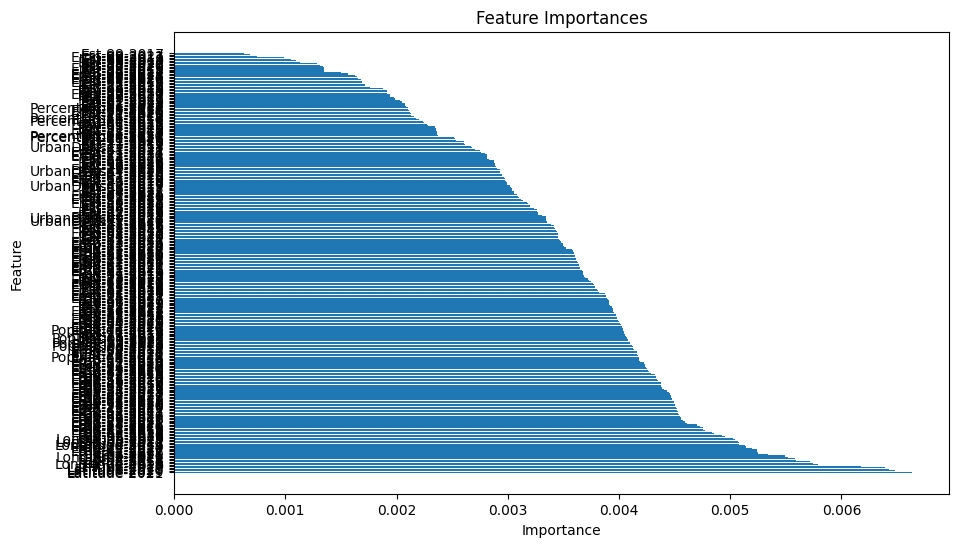

In [27]:
import matplotlib.pyplot as plt
feature_importances = model_RF.feature_importances_

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display feature importances
print(importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

In [44]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train XGBoost model
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

# Predict probabilities for test data
y_prob = xgb_model.predict_proba(X_test)[:, 1]  # Probability of positive class

# Thresholding: Convert probabilities to binary predictions
threshold = 0.5  # You can adjust this threshold as needed
y_pred = (y_prob > threshold).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Test Accuracy: 0.5859649122807018

Classification Report:
              precision    recall  f1-score   support

         0.0       0.37      0.23      0.28       204
         1.0       0.65      0.78      0.71       366

    accuracy                           0.59       570
   macro avg       0.51      0.51      0.50       570
weighted avg       0.55      0.59      0.56       570


Confusion Matrix:
[[ 47 157]
 [ 79 287]]


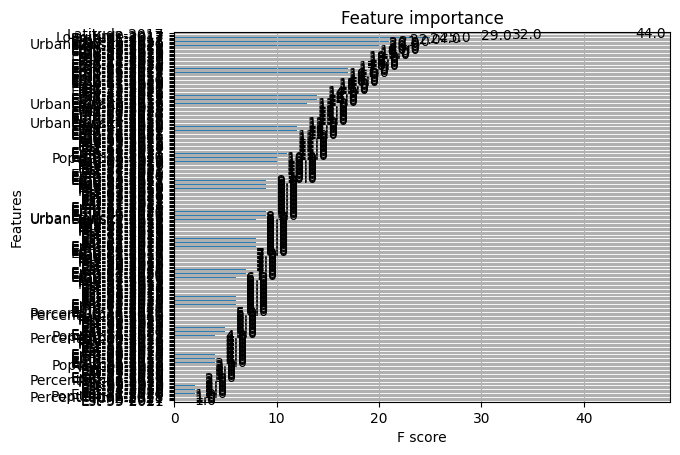

In [59]:
from xgboost import plot_importance
plot_importance(xgb_model)
plt.show()

In [60]:
feature_importance = xgb_model.get_booster().get_score()
sorted_feature_importance = sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)
for i in sorted_feature_importance:
    print(i)

('Latitude-2017', 44.0)
('Km2-2017', 32.0)
('Longitude-2017', 29.0)
('Emp-11-2017', 25.0)
('Pay-71-2017', 24.0)
('Emp-51-2018', 22.0)
('Emp-22-2021', 21.0)
('Emp-21-2018', 20.0)
('Emp-42-2017', 20.0)
('Emp-99-2018', 20.0)
('Pay-21-2021', 20.0)
('Pay-99-2020', 20.0)
('UrbanDensity-2020', 20.0)
('Emp-61-2018', 19.0)
('Pay-11-2019', 19.0)
('Pay-51-2021', 19.0)
('Pay-99-2019', 19.0)
('Emp-21-2020', 18.0)
('Emp-42-2021', 18.0)
('Emp-56-2021', 18.0)
('Est-11-2019', 18.0)
('Pay-11-2021', 18.0)
('Pay-21-2019', 18.0)
('Pay-42-2017', 18.0)
('Pay-56-2019', 18.0)
('Emp-23-2017', 17.0)
('Emp-51-2017', 17.0)
('Emp-56-2017', 17.0)
('Pay-21-2020', 17.0)
('Pay-51-2017', 17.0)
('Emp-11-2019', 16.0)
('Emp-21-2019', 16.0)
('Emp-42-2020', 16.0)
('Emp-53-2021', 16.0)
('Emp-71-2018', 16.0)
('Pay-22-2018', 16.0)
('Pay-53-2017', 16.0)
('Emp-72-2021', 15.0)
('Est-23-2021', 15.0)
('Est-72-2020', 15.0)
('Pay-11-2017', 15.0)
('Pay-11-2020', 15.0)
('Pay-61-2020', 15.0)
('Emp-11-2018', 14.0)
('Emp-21-2017', 14.0)
('

2017_increase

In [24]:
current_target_column = "2017_increase"
integrated_df = pd.read_csv(os.path.join(f"../output/bees/training",f"full-{current_target_column}-bees.csv"))
X_total, y_total = integrated_df.iloc[:, 3:], integrated_df.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X_total, y_total, test_size=0.2, random_state=42)
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

In [25]:
model_LR = LogisticRegression(max_iter=10000)
model_LR, y_pred = train_model(model_LR, X_train_imputed, y_train, X_test_imputed, y_test, False)

Model Fitted Successfully.
ROC-AUC Score 		: 60.0 %
Best Threshold 		: 0.507 
G-Mean 			: 0.586
Model Accuracy 		: 56.99999999999999 %

Classification Report:
              precision    recall  f1-score   support

         0.0       0.64      0.53      0.58       317
         1.0       0.52      0.62      0.57       253

    accuracy                           0.57       570
   macro avg       0.58      0.58      0.57       570
weighted avg       0.59      0.57      0.57       570



D:\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [26]:
model_RF = RandomForestClassifier(n_jobs=3, oob_score=True, n_estimators=100, criterion="gini")
model_RF, y_pred = train_model(model_RF, X_train_imputed, y_train, X_test_imputed, y_test, False)

Model Fitted Successfully.
ROC-AUC Score 		: 69.0 %
Best Threshold 		: 0.480 
G-Mean 			: 0.643
Model Accuracy 		: 63.0 %

Classification Report:
              precision    recall  f1-score   support

         0.0       0.72      0.55      0.62       317
         1.0       0.56      0.73      0.63       253

    accuracy                           0.63       570
   macro avg       0.64      0.64      0.63       570
weighted avg       0.65      0.63      0.63       570



In [27]:
model_SVM = SVC()
model_SVM, y_pred = train_model(model_LR, X_train_imputed, y_train, X_test_imputed, y_test, False)

Model Fitted Successfully.
ROC-AUC Score 		: 60.0 %
Best Threshold 		: 0.507 
G-Mean 			: 0.586
Model Accuracy 		: 56.99999999999999 %

Classification Report:
              precision    recall  f1-score   support

         0.0       0.64      0.53      0.58       317
         1.0       0.52      0.62      0.57       253

    accuracy                           0.57       570
   macro avg       0.58      0.58      0.57       570
weighted avg       0.59      0.57      0.57       570



D:\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [28]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

model_mlp = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=1000, random_state=42)
model_mlp, y_pred = train_model(model_mlp, X_train_imputed, y_train, X_test_imputed, y_test, False)

Model Fitted Successfully.
ROC-AUC Score 		: 51.0 %
Best Threshold 		: 1.000 
G-Mean 			: 0.511
Model Accuracy 		: 56.00000000000001 %

Classification Report:
              precision    recall  f1-score   support

         0.0       0.56      1.00      0.71       317
         1.0       0.00      0.00      0.00       253

    accuracy                           0.56       570
   macro avg       0.28      0.50      0.36       570
weighted avg       0.31      0.56      0.40       570



D:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2012_increase

In [29]:
current_target_column = "2012_increase"
integrated_df = pd.read_csv(os.path.join(f"../output/bees/training",f"full-{current_target_column}-bees.csv"))
X_total, y_total = integrated_df.iloc[:, 3:], integrated_df.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X_total, y_total, test_size=0.2, random_state=42)
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

In [30]:
model_LR = LogisticRegression(max_iter=10000)
model_LR, y_pred = train_model(model_LR, X_train_imputed, y_train, X_test_imputed, y_test, False)

Model Fitted Successfully.
ROC-AUC Score 		: 56.99999999999999 %
Best Threshold 		: 0.609 
G-Mean 			: 0.572
Model Accuracy 		: 60.0 %

Classification Report:
              precision    recall  f1-score   support

         0.0       0.37      0.14      0.20       207
         1.0       0.64      0.87      0.73       363

    accuracy                           0.60       570
   macro avg       0.51      0.50      0.47       570
weighted avg       0.54      0.60      0.54       570



D:\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [31]:
model_RF = RandomForestClassifier(n_jobs=3, oob_score=True, n_estimators=100, criterion="gini")
model_RF, y_pred = train_model(model_RF, X_train_imputed, y_train, X_test_imputed, y_test, False)

Model Fitted Successfully.
ROC-AUC Score 		: 57.99999999999999 %
Best Threshold 		: 0.620 
G-Mean 			: 0.563
Model Accuracy 		: 60.0 %

Classification Report:
              precision    recall  f1-score   support

         0.0       0.40      0.22      0.28       207
         1.0       0.65      0.82      0.72       363

    accuracy                           0.60       570
   macro avg       0.52      0.52      0.50       570
weighted avg       0.56      0.60      0.56       570



In [32]:
model_SVM = SVC()
model_SVM, y_pred = train_model(model_LR, X_train_imputed, y_train, X_test_imputed, y_test, False)

Model Fitted Successfully.
ROC-AUC Score 		: 56.99999999999999 %
Best Threshold 		: 0.609 
G-Mean 			: 0.572
Model Accuracy 		: 60.0 %

Classification Report:
              precision    recall  f1-score   support

         0.0       0.37      0.14      0.20       207
         1.0       0.64      0.87      0.73       363

    accuracy                           0.60       570
   macro avg       0.51      0.50      0.47       570
weighted avg       0.54      0.60      0.54       570



D:\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [33]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

model_mlp = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=1000, random_state=42)
model_mlp, y_pred = train_model(model_mlp, X_train_imputed, y_train, X_test_imputed, y_test, False)

Model Fitted Successfully.
ROC-AUC Score 		: 54.0 %
Best Threshold 		: 1.000 
G-Mean 			: 0.526
Model Accuracy 		: 59.0 %

Classification Report:
              precision    recall  f1-score   support

         0.0       0.42      0.37      0.39       207
         1.0       0.66      0.71      0.69       363

    accuracy                           0.59       570
   macro avg       0.54      0.54      0.54       570
weighted avg       0.58      0.59      0.58       570



2007_increase

In [34]:
current_target_column = "2007_increase"
integrated_df = pd.read_csv(os.path.join(f"../output/bees/training",f"full-{current_target_column}-bees.csv"))
X_total, y_total = integrated_df.iloc[:, 3:], integrated_df.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X_total, y_total, test_size=0.2, random_state=42)
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

In [35]:
model_LR = LogisticRegression(max_iter=10000)
model_LR, y_pred = train_model(model_LR, X_train_imputed, y_train, X_test_imputed, y_test, False)

Model Fitted Successfully.
ROC-AUC Score 		: 56.99999999999999 %
Best Threshold 		: 0.612 
G-Mean 			: 0.559
Model Accuracy 		: 61.0 %

Classification Report:
              precision    recall  f1-score   support

         0.0       0.40      0.11      0.17       209
         1.0       0.64      0.90      0.75       361

    accuracy                           0.61       570
   macro avg       0.52      0.51      0.46       570
weighted avg       0.55      0.61      0.54       570



D:\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [36]:
model_RF = RandomForestClassifier(n_jobs=3, oob_score=True, n_estimators=100, criterion="gini")
model_RF, y_pred = train_model(model_RF, X_train_imputed, y_train, X_test_imputed, y_test, False)

Model Fitted Successfully.
ROC-AUC Score 		: 56.00000000000001 %
Best Threshold 		: 0.630 
G-Mean 			: 0.545
Model Accuracy 		: 61.0 %

Classification Report:
              precision    recall  f1-score   support

         0.0       0.42      0.16      0.23       209
         1.0       0.64      0.87      0.74       361

    accuracy                           0.61       570
   macro avg       0.53      0.52      0.49       570
weighted avg       0.56      0.61      0.55       570



In [37]:
model_SVM = SVC()
model_SVM, y_pred = train_model(model_LR, X_train_imputed, y_train, X_test_imputed, y_test, False)

Model Fitted Successfully.
ROC-AUC Score 		: 56.99999999999999 %
Best Threshold 		: 0.612 
G-Mean 			: 0.559
Model Accuracy 		: 61.0 %

Classification Report:
              precision    recall  f1-score   support

         0.0       0.40      0.11      0.17       209
         1.0       0.64      0.90      0.75       361

    accuracy                           0.61       570
   macro avg       0.52      0.51      0.46       570
weighted avg       0.55      0.61      0.54       570



D:\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [38]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

model_mlp = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=1000, random_state=42)
model_mlp, y_pred = train_model(model_mlp, X_train_imputed, y_train, X_test_imputed, y_test, False)

Model Fitted Successfully.
ROC-AUC Score 		: 53.0 %
Best Threshold 		: 0.000 
G-Mean 			: 0.536
Model Accuracy 		: 55.00000000000001 %

Classification Report:
              precision    recall  f1-score   support

         0.0       0.40      0.44      0.42       209
         1.0       0.66      0.62      0.64       361

    accuracy                           0.55       570
   macro avg       0.53      0.53      0.53       570
weighted avg       0.56      0.55      0.56       570

